In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

In [2]:
# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

# Create Graph using Bipartite Projection on Arxiv Dataset

In [4]:
data = 'data/arxiv_network_science_data.csv'

df = pd.read_csv(data)

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Dustin Nguyen,Neural ODEs as a discovery tool to characteriz...
1,Yuan-Sen Ting,Neural ODEs as a discovery tool to characteriz...
2,Todd A. Thompson,Neural ODEs as a discovery tool to characteriz...
3,Sebastian Lopez,Neural ODEs as a discovery tool to characteriz...
4,Laura A. Lopez,Neural ODEs as a discovery tool to characteriz...


In [5]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

G = nx.k_core(G, 2) # no isolates or two-node groups

In [6]:
print(nx.info(G))

AttributeError: module 'networkx' has no attribute 'info'

# Community Detection + Community Analysis

There's two parts to what I am attempting today.
- I need to use community detection to identify communities in the network.
- I can then use network science and data science to identify interesting communities

By interesting, I mean not stars. I am looking for complex ecosystems. So, I will identify communities, then attempt to detect more complex ecosystems by using triangles and density.

## Community Detection

In [7]:
import community as community_louvain

partition = community_louvain.best_partition(G, resolution=0.01, random_state=1337) # 10 was good for this network

In [8]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

# remove junk; identify relevant communities

community_df['community'].value_counts()[0:20]

community
10829    186
6171     167
6852     145
3482     138
6082     128
10435    118
7308     110
6251     104
4165     102
3330     100
3593      91
3275      83
6732      71
9863      69
7890      68
6211      64
6568      64
2590      63
11093     59
7645      58
Name: count, dtype: int64

In [9]:
community_node_counts = community_df['community'].value_counts()

community_size_df = pd.DataFrame(community_node_counts).reset_index()
community_size_df.columns = ['community', 'node_count']

# just to speed up this experiment
community_size_df = community_size_df[community_size_df['node_count'] > 10]

community_size_df.head()

,community,node_count
0,10829,186
1,6171,167
2,6852,145
3,3482,138
4,6082,128


In [10]:
community_size_df.shape

(743, 2)

## Capture Community Context

In [11]:
community_df.head()

,node,community
0,Dustin Nguyen,2
1,Yuan-Sen Ting,397
2,Todd A. Thompson,2
3,Sebastian Lopez,2
4,Laura A. Lopez,2


In [12]:
community_size_df.head(1)

,community,node_count
0,10829,186


In [13]:
def get_community_nodes(community_df, community):

    return sorted(community_df[community_df['community']==community]['node'].values)

In [14]:
def get_community_context(community_size_df, community_df, G):

    G = G.copy()

    communities = {}

    for row in community_size_df.iterrows():

        data = row[1]
        community = data['community']
        node_count = data['node_count']
        
        nodes = get_community_nodes(community_df, community)
        G_sub = G.subgraph(nodes)

        # starting with density today; will add on more context later
        density = nx.density(G_sub)
        
        communities[community] = {}

        communities[community]['G'] = G_sub
        communities[community]['density'] = density
        communities[community]['node_count'] = len(G_sub.nodes)
        
    return communities

In [15]:
community_context_dict = get_community_context(community_size_df, community_df, G)

In [16]:
community_context_df = pd.DataFrame(community_context_dict).T.reset_index()
community_context_df.columns = ['community', 'G', 'density', 'node_count']

community_context_df.head()

,community,G,density,node_count
0,10829,"(Nattida Samanso, Dong-Kyu Jung, Motoki Kino, ...",0.343156,186
1,6171,"(D. Cichon, K. Ni, L. Baudis, J. R. Angevaare,...",1.0,167
2,6852,"(U. Straumann, D. Pitzl, P. Robmann, D. Wegene...",1.0,145
3,3482,"(J. Peloton, J. -P. Rivet, M. Sabil, M. Masek,...",0.879509,138
4,6082,"(Raffaella Schneider, Tanja Hinderer, B. S. Sa...",0.61159,128


<Axes: ylabel='Frequency'>

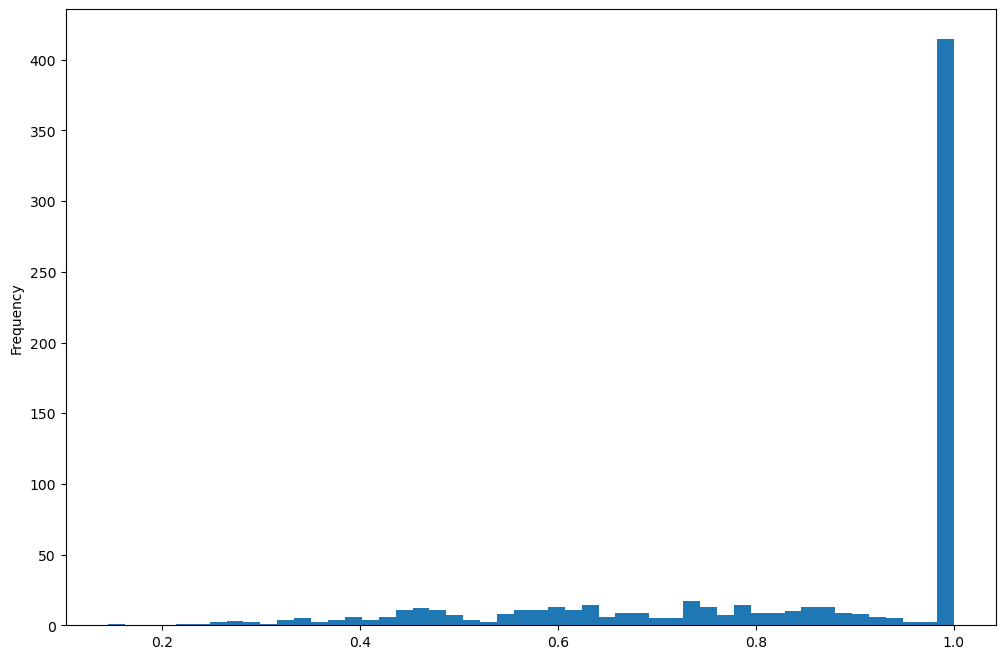

In [17]:
community_context_df['density'].plot.hist(bins=50, figsize=(12,8))

#### Investigate Communities

In [19]:
def show_author_papers(df, G):
    
    G = G.copy()
    
    check_nodes = G.nodes

    return sorted(df[df['authors'].isin(check_nodes)]['title'].unique())

In [20]:
def fetch_communities(community_context_df, min_density, max_density, max_nodes=None):
    
    if max_nodes==None:
        community_context_df['node_count'].sum()
    
    community_context_df = community_context_df.copy()

    mask = (community_context_df['density']>min_density) \
        & (community_context_df['density']<max_density)  \
        & (community_context_df['node_count']<max_nodes)
    
    community_context_df = community_context_df[mask].copy()
    community_context_df = community_context_df.sample(10) # grabbing ten to see the ranges

    community_context_df.sort_values('density', inplace=True)
    communities = community_context_df['community'].values[0:10]
    
    return communities

In [21]:
def draw_community(G_check):

    print('Density: {}'.format(nx.density(G_check)))
    print('Node Count: {}'.format(len(G_check.nodes)))
    return draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

In [22]:
min_density = 0.1
max_density = 0.3
max_nodes = 100

communities = fetch_communities(community_context_df, min_density=min_density, max_density=max_density, max_nodes=max_nodes)
communities

array([ 6211,  3744,   767, 10365,  1648,  3789,   457,  5883,  3469,
       10292], dtype=int64)

Density: 0.1453373015873016
Node Count: 64


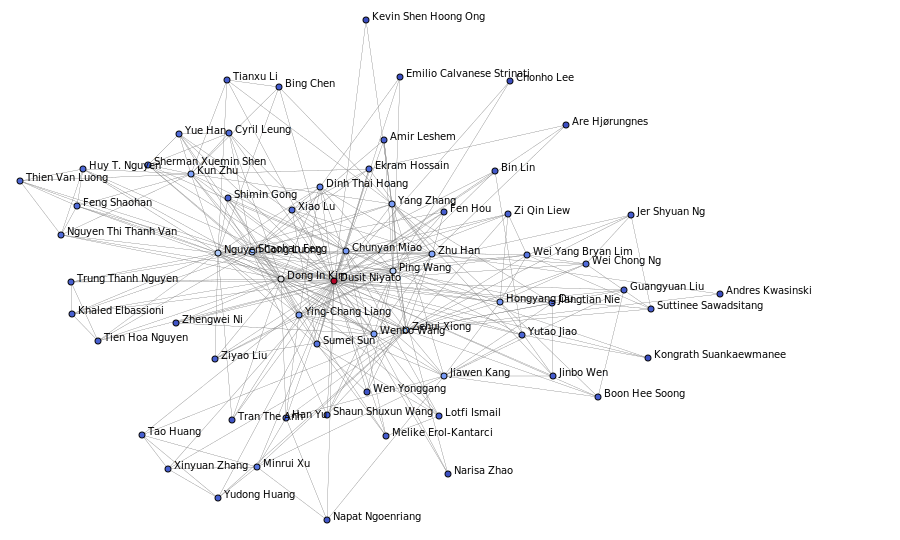

In [23]:
G_check = community_context_dict[communities[0]]['G']
draw_community(G_check)

In [24]:
show_author_papers(df, G_check)

['A Contract-based Incentive Mechanism for Energy Harvesting-based Internet of Things',
 'A Cooperative Bayesian Nonparametric Framework for Primary User Activity Monitoring in Cognitive Radio Network',
 'A Distributed Merge and Split Algorithm for Fair Cooperation in Wireless Networks',
 'A Dynamic Hierarchical Framework for IoT-assisted Metaverse Synchronization',
 'A Layered Coalitional Game Framework of Wireless Relay Network',
 'A Learning-Based Coexistence Mechanism for LAA-LTE Based HetNets',
 'A Method for Expressing and Displaying the Vehicle Behavior Distribution in Maintenance Work Zones',
 'A Real-time Group Auction System for Efficient Allocation of Cloud Internet Applications',
 'A Socially-Aware Incentive Mechanism for Mobile Crowdsensing Service Market',
 'A Stackelberg Game Approach Towards Socially-Aware Incentive Mechanisms for Mobile Crowdsensing (Online report)',
 'A Survey on Applications of Game Theory in Blockchain',
 'A Survey on Mobile Edge Networks: Convergen

Density: 0.229064039408867
Node Count: 29


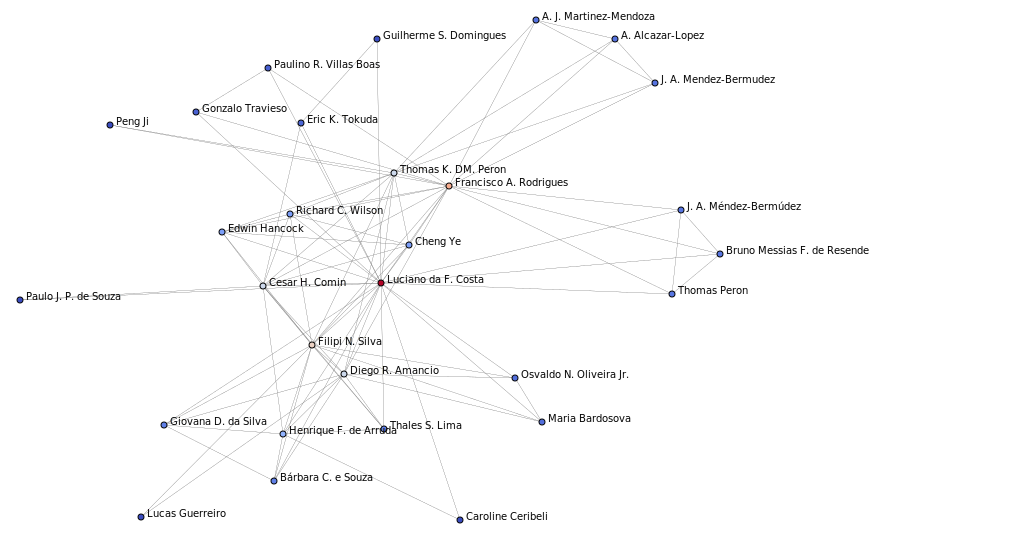

In [25]:
G_check = community_context_dict[communities[1]]['G']
draw_community(G_check)

In [26]:
show_author_papers(df, G_check)

['A comparative analysis of knowledge acquisition performance in complex networks',
 'A comparative analysis of local network similarity measurements: application to author citation networks',
 'A machine learning approach to predicting dynamical observables from network structure',
 'Analyzing Trails in Complex Networks',
 'Analyzing complex networks through correlations in centrality measurements',
 'Automatic Network Fingerprinting through Single-Node Motifs',
 'Border trees of complex networks',
 'Chain motifs: The tails and handles of complex networks',
 'Characterization and space embedding of directed graphs and social networks through magnetic Laplacians',
 'Characterizing Width Uniformity by Wave Propagation',
 'City Motifs as Revealed by Similarity Between Hierarchical Features',
 'Comparing the writing style of real and artificial papers',
 'Complex Networks of Functions',
 'Complex systems: features, similarity and connectivity',
 'Connecting Network Science and Information

Density: 0.24630541871921183
Node Count: 29


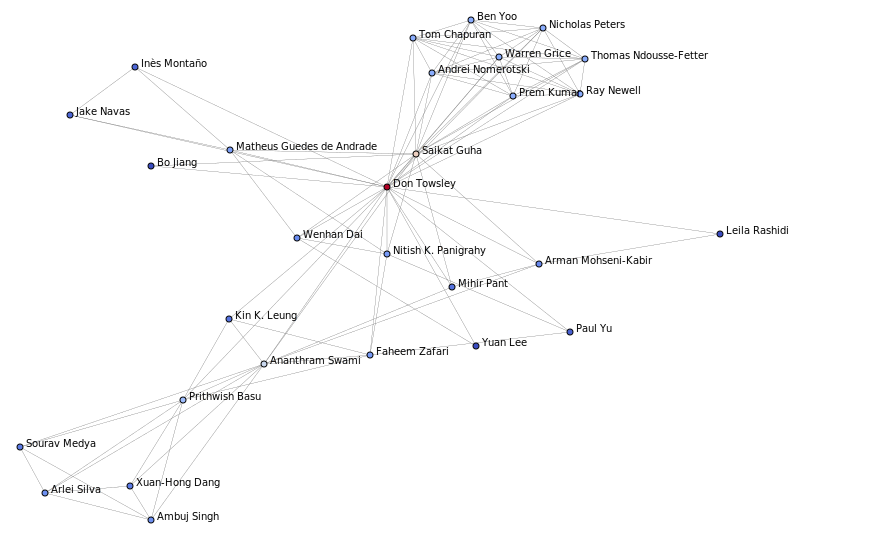

In [27]:
G_check = community_context_dict[communities[2]]['G']
draw_community(G_check)

In [28]:
show_author_papers(df, G_check)

['A Distance Measure for the Analysis of Polar Opinion Dynamics in Social Networks',
 'A TTL-based Approach for Content Placement in Edge Networks',
 'A marine radioisotope gamma-ray spectrum analysis method based on Monte Carlo simulation and MLP neural network',
 'An Exploratory Study of Stock Price Movements from Earnings Calls',
 'Broadcast Analysis for Large Cooperative Wireless Networks',
 'Graph Encoding and Neural Network Approaches for Volleyball Analytics: From Game Outcome to Individual Play Predictions',
 'Information Cascades in Feed-based Networks of Users with Limited Attention',
 'Learnable Digital Twin for Efficient Wireless Network Evaluation',
 'Learning Features of Network Structures Using Graphlets',
 'Learning to Generate Networks',
 'MON: Mission-optimized Overlay Networks',
 'Maximizing Coverage Centrality via Network Design: Extended Version',
 'Network Classification in Temporal Networks Using Motifs',
 'Network Robustness via Global k-cores',
 'Node Dominance

Density: 0.25925925925925924
Node Count: 27


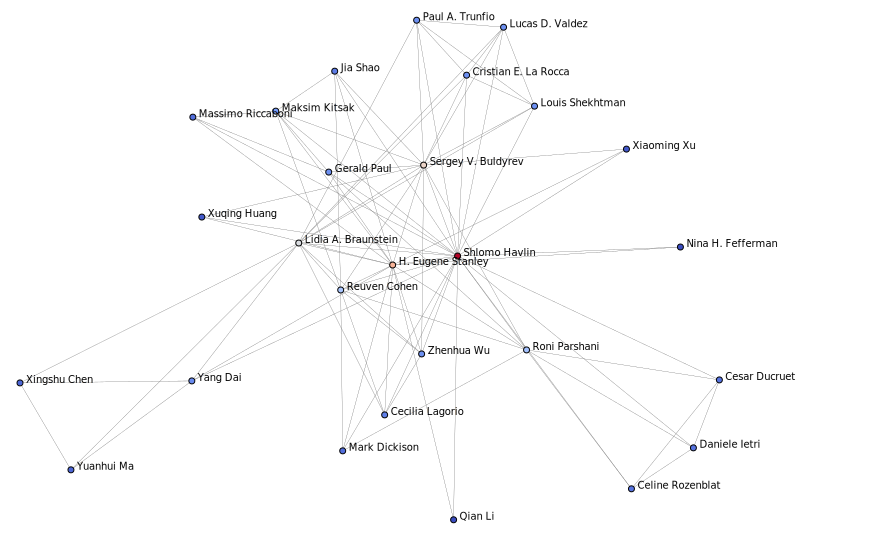

In [29]:
G_check = community_context_dict[communities[3]]['G']
draw_community(G_check)

In [30]:
show_author_papers(df, G_check)

['$k$-core percolation on complex networks: Comparing random, localized and targeted attacks',
 'Altering control modes of complex networks based on edge removal',
 'Assortativity Decreases the Robustness of Interdependent Networks',
 'Avalanches in Breakdown and Fracture Processes',
 'Betweenness Centrality of Fractal and Non-Fractal Scale-Free Model Networks and Tests on Real Networks',
 'Cascade of failures in coupled network systems with multiple support-dependent relations',
 'Cascading Failures in Complex Networks',
 'Catastrophic cascade of failures in interdependent networks',
 'Classes of behavior of small-world networks',
 'Complementarity in Complex Networks',
 'Conditions for viral influence spreading through multiplex correlated social networks',
 'Containing misinformation spreading in temporal social networks',
 'Current Flow in Random Resistor Networks: The Role of Percolation in Weak and Strong Disorder',
 'Demographic and Structural Characteristics to Rationalize Link

Density: 0.2645161290322581
Node Count: 31


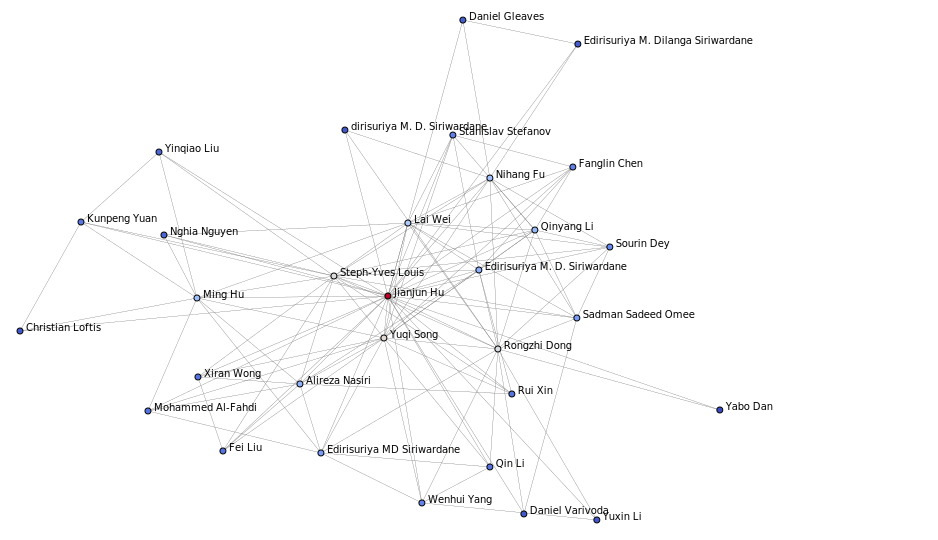

In [31]:
G_check = community_context_dict[communities[4]]['G']
draw_community(G_check)

In [32]:
show_author_papers(df, G_check)

['Active learning based generative design for the discovery of wide bandgap materials',
 'AlphaCrystal: Contact map based crystal structure prediction using deep learning',
 'Crystal Transformer: Self-learning neural language model for Generative and Tinkering Design of Materials',
 'Crystal structure prediction using neural network potential and age-fitness Pareto genetic algorithm',
 'Discovery of 2D materials using Transformer Network based Generative Design',
 'Generative Design of inorganic compounds using deep diffusion language models',
 'Global Attention based Graph Convolutional Neural Networks for Improved Materials Property Prediction',
 'High-throughput discovery of novel cubic crystal materials using deep generative neural networks',
 'Inverse Design of Composite Metal Oxide Optical Materials based on Deep Transfer Learning',
 'Lattice Thermal Conductivity Prediction using Symbolic Regression and Machine Learning',
 'MLatticeABC: Generic Lattice Constant Prediction of Crys

Density: 0.2678062678062678
Node Count: 27


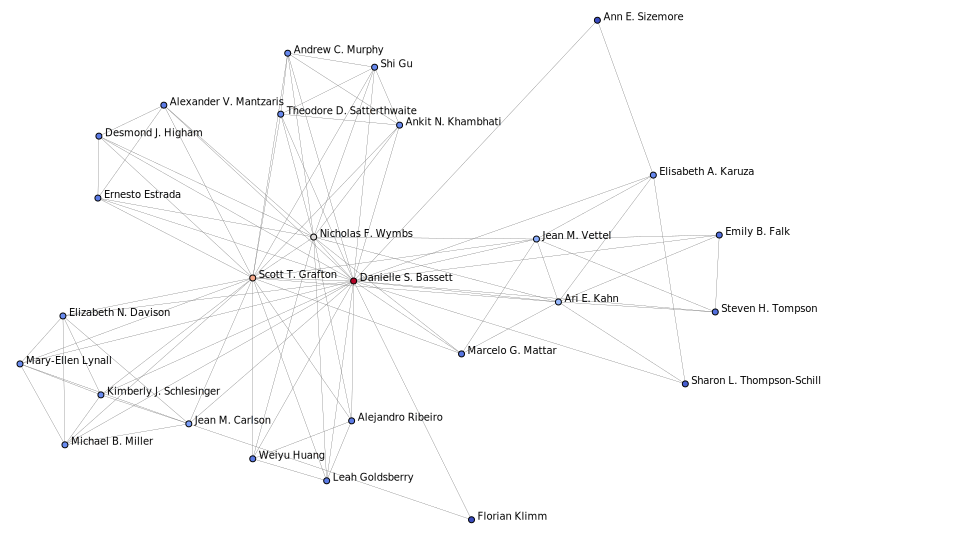

In [33]:
G_check = community_context_dict[communities[5]]['G']
draw_community(G_check)

In [34]:
show_author_papers(df, G_check)

['A Network Science Summer Course for High School Students',
 'A practical guide to methodological considerations in the controllability of structural brain networks',
 'A statistical mechanics description of environmental variability in metabolic networks',
 'Are Social Networks Really Balanced?',
 'Brain Network Adaptability Across Task States',
 'Brain Network Architecture: Implications for Human Learning',
 'Centrality-Friendship Paradoxes: When Our Friends Are More Important Than Us',
 'Communicability Angles Reveal Critical Edges for Network Consensus Dynamics',
 'Communicability Graph and Community Structures in Complex Networks',
 'Communicability in complex brain networks',
 'Communicability in complex networks',
 'Complex Networks as Hypergraphs',
 'Compressibility of complex networks',
 'Conformational Control of Mechanical Networks',
 'Connecting the Dots: Identifying Network Structure via Graph Signal Processing',
 'Convolutional Neural Networks Via Node-Varying Graph Filt

Density: 0.275609756097561
Node Count: 41


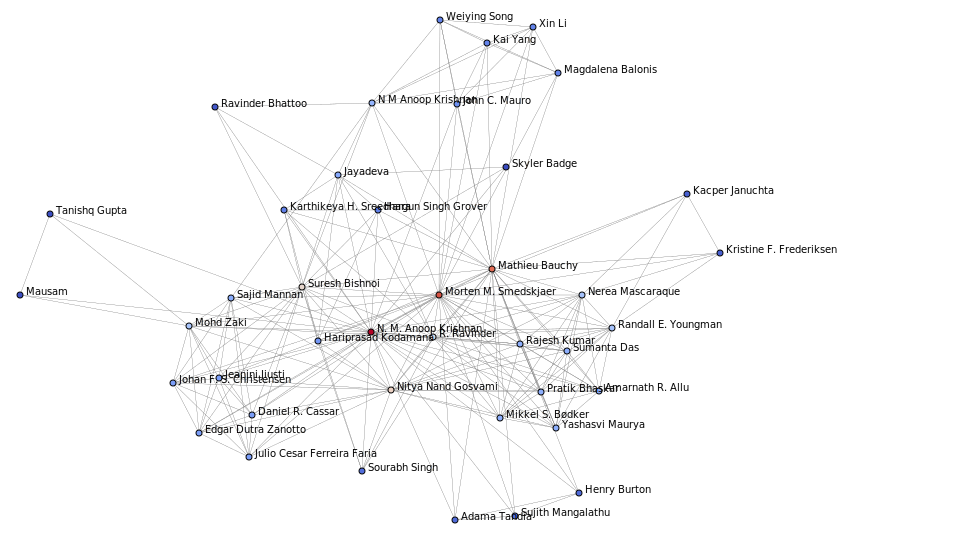

In [35]:
G_check = community_context_dict[communities[6]]['G']
draw_community(G_check)

In [36]:
show_author_papers(df, G_check)

['A New Transferable Interatomic Potential for Molecular Dynamics Simulations of Borosilicate Glasses',
 'Applying deep neural networks to the detection and space parameter estimation of compact binary coalescence with a network of gravitational wave detectors',
 'CONet: A Cognitive Ocean Network',
 'Cooling Rate Effects on the Structure of 45S5 Bioglass: Computational and Experimental Evidence of Si--P Avoidance',
 'Cooling-Rate Effects in Sodium Silicate Glasses: Bridging the Gap between Molecular Dynamics Simulations and Experiments',
 'Deep Learning Aided Rational Design of Oxide Glasses',
 'Designing optical glasses by machine learning coupled with a genetic algorithm',
 'DiSCoMaT: Distantly Supervised Composition Extraction from Tables in Materials Science Articles',
 'Direct Experimental Evidence for Differing Reactivity Alterations of Minerals following Irradiation: The Case of Calcite and Quartz',
 'Discovering Symbolic Laws Directly from Trajectories with Hamiltonian Graph Ne

Density: 0.27705627705627706
Node Count: 22


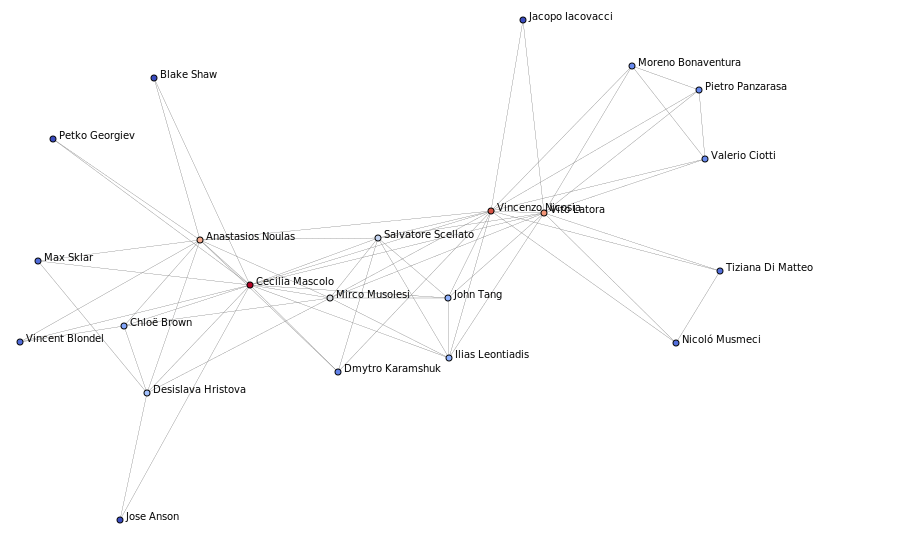

In [37]:
G_check = community_context_dict[communities[7]]['G']
draw_community(G_check)

In [38]:
show_author_papers(df, G_check)

['A Multilayer Approach to Multiplexity and Link Prediction in Online Geo-Social Networks',
 'A place-focused model for social networks in cities',
 'A topological criterion for filtering information in complex brain networks',
 'Anticipatory Mobile Computing: A Survey of the State of the Art and Research Challenges',
 'Applications of Temporal Graph Metrics to Real-World Networks',
 'Centralities of Nodes and Influences of Layers in Large Multiplex Networks',
 'Characteristic exponents of complex networks',
 'Characterizing Learning Dynamics of Deep Neural Networks via Complex Networks',
 'Cultural Investment and Urban Socio-Economic Development: A Geo-Social Network Approach',
 'Determinants of public cooperation in multiplex networks',
 'Disentangling shock diffusion on complex networks: Identification through graph planarity',
 'Economic Small-World Behavior in Weighted Networks',
 'Efficiency of Scale-Free Networks: Error and Attack Tolerance',
 'Emergence of multiplex communities

Density: 0.2875816993464052
Node Count: 18


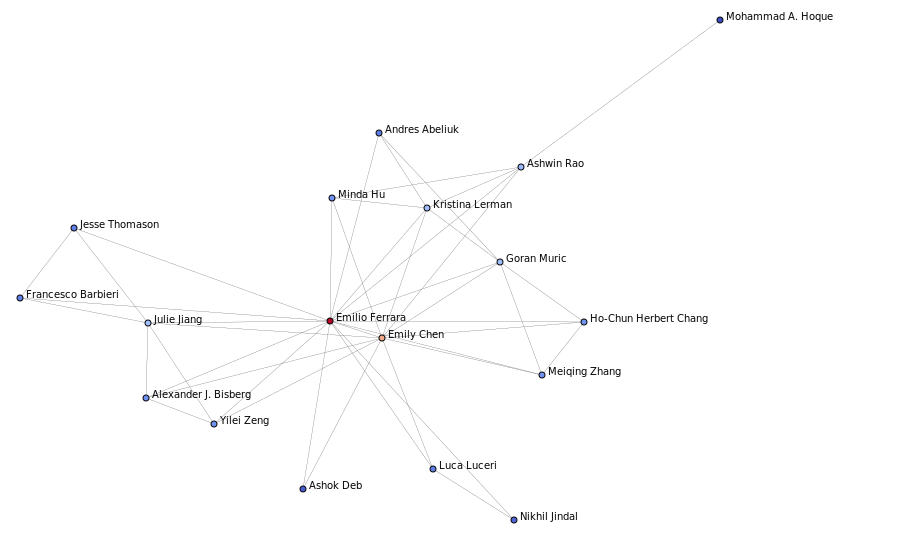

In [39]:
G_check = community_context_dict[communities[8]]['G']
draw_community(G_check)

In [40]:
show_author_papers(df, G_check)

['#Election2020: The First Public Twitter Dataset on the 2020 US Presidential Election',
 'A Large-Scale Community Structure Analysis In Facebook',
 'A Parameterized Centrality Metric for Network Analysis',
 'Botometer 101: Social bot practicum for computational social scientists',
 'Capturing Edge Attributes via Network Embedding',
 'Centrality Metric for Dynamic Networks',
 'Clique Densification in Networks',
 'Co-Contagion Diffusion on Multilayer Networks',
 'Collaboration Drives Individual Productivity',
 'Complex Systems of Secrecy: The Offshore Networks of Oligarchs',
 "Computational Social Scientist Beware: Simpson's Paradox in Behavioral Data",
 'Contagion dynamics of extremist propaganda in social networks',
 'Deep Neural Networks for Bot Detection',
 'Defining and identifying Sleeping Beauties in science',
 'Detecting criminal organizations in mobile phone networks',
 'Emergence of Structural Inequalities in Scientific Citation Networks',
 'Enhancing community detection using

Density: 0.29064039408866993
Node Count: 29


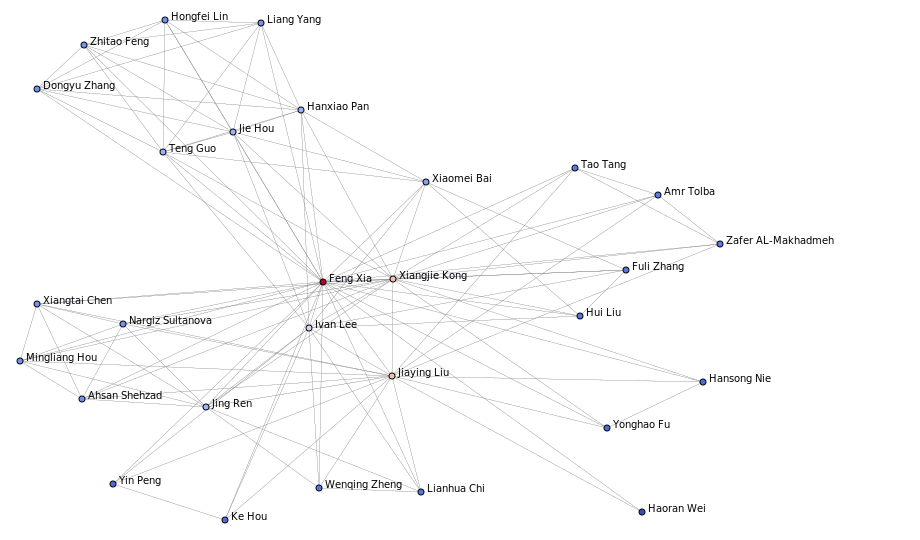

In [41]:
G_check = community_context_dict[communities[9]]['G']
draw_community(G_check)

In [42]:
show_author_papers(df, G_check)

['An Energy-Efficient Localization Strategy for Smartphones',
 'An Overview on Evaluating and Predicting Scholarly Article Impact',
 'Big Networks: A Survey',
 'CHIEF: Clustering with Higher-order Motifs in Big Networks',
 'DINE: A Framework for Deep Incomplete Network Embedding',
 'Data-driven Computational Social Science: A Survey',
 'Energy Efficient Ant Colony Algorithms for Data Aggregation in Wireless Sensor Networks',
 'Graph Learning: A Survey',
 'How to optimize an academic team when the outlier member is leaving?',
 'Judging a Book by Its Cover: The Effect of Facial Perception on Centrality in Social Networks',
 'MODEL: Motif-based Deep Feature Learning for Link Prediction',
 'Matching Algorithms: Fundamentals, Applications and Challenges',
 'Multivariate Relations Aggregation Learning in Social Networks',
 'Network Representation Learning: From Traditional Feature Learning to Deep Learning',
 'Neural Feedback Scheduling of Real-Time Control Tasks',
 'On Content-centric Wirel

In [63]:
# seems to be that...
# more dense: collaborative papers but fewer
# less dense: more single author papers causing network sparcity

# 'Online-updated High-order Collaborative Networks for Single Image Deraining',
# found a paper about collaborative papers while studying author collaboration :D